In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import os
import sys

In [31]:
#open file
#user can change path on his/her own
folderpath = 'D:/FIFA19'
if os.path.isdir(folderpath):
    print("directory is found。")
else:
    print("directory is not found。")
    sys.exit(0)
    
filepath = folderpath + '/data.csv'
if os.path.isfile(filepath):
    print("file is found。")
else:
    print("file is not found。")
    sys.exit(0)
df = pd.read_csv("D:/FIFA19/data.csv")
df.info()

directory is found。
file is found。
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   

In [37]:
#drop non-useful attributes
drop_list = ["ID","Name","Photo","Nationality","Flag","Club","Club Logo","Special","Work Rate","Real Face","Jersey Number",\
             "Joined","Loaned From","Contract Valid Until","Crossing","Finishing","HeadingAccuracy","ShortPassing","Volleys",\
             "Dribbling","Curve","FKAccuracy","LongPassing","BallControl","Acceleration","SprintSpeed","Agility","Reactions",\
             "Balance","ShotPower","Jumping","Stamina","Strength","LongShots","Aggression","Interceptions","Positioning",\
             "Vision","Penalties","Composure","Marking","StandingTackle","SlidingTackle","GKDiving","GKHandling","GKKicking",\
             "GKPositioning","GKReflexes","LS","ST","RS","LW","LF","CF","RF","RW","LAM","CAM","RAM","LM","LCM","CM","RCM","RM",\
             "LWB","LDM","CDM","RDM","RWB","LB","LCB","CB","RCB","RB","Overall","Position"]
fifa_data = df.drop(drop_list,axis = 1)

#fill nan value to 0
fifa_data = fifa_data.fillna("0")

#handle "€","M","K" in value,wage and release clause attributes
for i in range(len(fifa_data["Value"])):
    temp_str = fifa_data["Value"][i]
    temp_str = temp_str.replace("€","")
    if "M" in temp_str:
        temp_str = temp_str.replace("M","")
        temp_str = str(int(float(temp_str)*1000000))
    elif "K" in temp_str:
        temp_str = temp_str.replace("K","")
        temp_str = str(int(float(temp_str)*1000))
    fifa_data.loc[i,"Value"] = temp_str

for i in range(len(fifa_data["Wage"])):
    temp_str = fifa_data["Wage"][i]
    temp_str = temp_str.replace("€","")
    if "M" in temp_str:
        temp_str = temp_str.replace("M","")
        temp_str = str(int(float(temp_str)*1000000))
    elif "K" in temp_str:
        temp_str = temp_str.replace("K","")
        temp_str = str(int(float(temp_str)*1000))
    fifa_data.loc[i,"Wage"] = temp_str
        
for i in range(len(fifa_data["Release Clause"])):
    temp_str = fifa_data["Release Clause"][i]
    temp_str = temp_str.replace("€","")
    if "M" in temp_str:
        temp_str = temp_str.replace("M","")
        temp_str = str(int(float(temp_str)*1000000))
    elif "K" in temp_str:
        temp_str = temp_str.replace("K","")
        temp_str = str(int(float(temp_str)*1000))    
    fifa_data.loc[i,"Release Clause"] = temp_str
        
#handle Preferred Foot by translation in 0(Left) and 1(Right)
for i in range(len(fifa_data["Preferred Foot"])):
    if "Left" in fifa_data["Preferred Foot"][i]:
        fifa_data.loc[i,"Preferred Foot"] = "0"
    else:
        fifa_data.loc[i,"Preferred Foot"] = "1"
    
#handle body type by quantizing
monsters = ['C. Ronaldo','Messi','Neymar','Akinfenwa','Shaqiri','Courtois']
for i in range(len(fifa_data["Body Type"])):
    if fifa_data["Body Type"][i] in monsters:
        fifa_data.loc[i,"Body Type"] = "4"
    elif fifa_data["Body Type"][i] == "Stocky":
        fifa_data.loc[i,"Body Type"] = "3"
    elif fifa_data["Body Type"][i] == "Normal":
        fifa_data.loc[i,"Body Type"] = "2"
    elif fifa_data["Body Type"][i] == "Lean":
        fifa_data.loc[i,"Body Type"] = "1"
    else:
        fifa_data.loc[i,"Body Type"] = "0"
        
#handle Height by translating in CM
for i in range(len(fifa_data["Height"])):
    temp_str = fifa_data["Height"][i]
    temp_str = temp_str.replace("\'",".")
    inch = float(temp_str) % 1 * 100
    if inch > 12:
        inch/=10
    temp_str = str(float("{:.2f}".format((float(temp_str) // 1 * 12 + inch) * 2.54)))
    fifa_data.loc[i,"Height"] = temp_str
    
#handle Weight by translating in KG
for i in range(len(fifa_data["Weight"])):
    temp_str = fifa_data["Weight"][i]
    temp_str = temp_str.replace("lbs","")
    temp_str = str(float("{:.2f}".format(float(temp_str) * 0.453)))
    fifa_data.loc[i,"Weight"] = temp_str


In [33]:
#take overall as standard picking rule
fifa_ovr = df[["Overall","Name","Position"]]

#split fifa_data into trainning data and 
train_data, test_data, train_ovr, test_ovr = train_test_split(fifa_data,fifa_ovr,test_size = 0.5)
test_name = pd.DataFrame({"Name":test_ovr["Name"]})
test_pos = pd.DataFrame({"Position":test_ovr["Position"]})
train_ovr = train_ovr.drop(["Name","Position"],axis = 1)
test_ovr = test_ovr.drop(["Name","Position"],axis = 1)

In [34]:
#copy data
train_Ddata = train_data
train_Dovr = train_ovr
test_Ddata = test_data
test_Dovr = test_ovr
test_Dname = test_name
test_Dpos = test_pos

#build "DecisionTree" classifier
clf = tree.DecisionTreeClassifier()
fifa_clf = clf.fit(train_Ddata, train_Dovr)

#predict
fifa_Dpredited = fifa_clf.predict(test_Ddata)

#rearrange test standard overalls' index 
test_Dovr.index = range(len(test_Dovr))
test_Dname.index = range(len(test_Dname))
test_Dpos.index = range(len(test_Dpos))

#accuracy
accuracy = metrics.accuracy_score(test_Dovr,fifa_Dpredited)
print(accuracy)

#concate predicted answer and standard overall
df_Dpredicted = pd.DataFrame({'Score':fifa_Dpredited}) 
Dresult = {
    'Name': [],
    'Position': [],
    'Score': [],
    'Overall': []
}
df_Dresult = pd.DataFrame(Dresult)
for i in range(len(test_Dovr)):
    df_Dresult = df_Dresult.append({
        'Name': test_Dname['Name'][i],
        'Position': test_Dpos['Position'][i],
        'Score': df_Dpredicted['Score'][i],
        'Overall': test_Dovr['Overall'][i]
    },ignore_index=True)
df_Dresult.sort_values(by = 'Score',inplace=True,ascending=False,ignore_index=True)
print(df_Dresult)

#output result to csv
output_PATH = 'D:/FIFA19/fifa_D_result.csv'
df_Dresult.to_csv(output_PATH,index=0)



0.9973637961335676
              Name Position  Score  Overall
0         L. Messi       RF   94.0     94.0
1        Neymar Jr       LW   94.0     92.0
2         J. Oblak       GK   91.0     90.0
3        L. Suárez       RS   91.0     91.0
4         D. Godín       CB   91.0     90.0
...            ...      ...    ...      ...
9099   K. Fujikawa       CM   47.0     47.0
9100    J. Livesey       GK   47.0     47.0
9101  Zhang Yufeng       CM   47.0     47.0
9102  M. Baldisimo       CM   47.0     47.0
9103      J. Young       ST   47.0     47.0

[9104 rows x 4 columns]


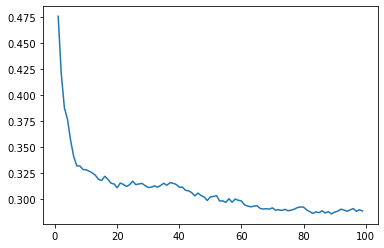

                 Name Position  Score  Overall
0      R. Lewandowski       ST   94.0     90.0
1            L. Messi       RF   91.0     94.0
2     Roberto Firmino      CAM   91.0     86.0
3             S. Mané       LM   91.0     86.0
4           Neymar Jr       LW   91.0     92.0
...               ...      ...    ...      ...
9099       C. Hawkins       GK   47.0     48.0
9100   D. Walker-Rice       RW   47.0     47.0
9101         C. Maher       RB   47.0     48.0
9102       J. Livesey       GK   47.0     47.0
9103       L. Watkins       CM   46.0     47.0

[9104 rows x 4 columns]


In [35]:
#copy data
train_Kdata = train_data
train_Kovr = train_ovr
test_Kdata = test_Ddata
test_Kovr = test_ovr
test_Kname = test_name
test_Kpos = test_pos
train_Kovr = train_Kovr.values.ravel()

#Because we don't know how to choose K index in KNN algorithm, 
#so we give a test to bulid many different K classifier. 
accuracy = []
for k in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_Kdata, train_Kovr)
    y_pred = knn.predict(test_Kdata)
    accuracy.append(metrics.accuracy_score(test_Kovr, y_pred))
k_range = range(1,100)
plt.plot(k_range, accuracy)
plt.savefig("D:/FIFA19/K_selection.png")
plt.show()

#build "KNN" classifier
knn = KNeighborsClassifier(n_neighbors=1)
knn = knn.fit(train_Kdata, train_Kovr)

#predict
fifa_Kpredited = knn.predict(test_Kdata)

#test standard overall rearrange index
test_Kovr.index = range(len(test_Kovr))
test_Kname.index = range(len(test_Kname))
test_Kpos.index = range(len(test_Kpos))

#accuracy
accuracy = metrics.accuracy_score(test_Kovr,fifa_Kpredited)

#concate predicted answer and standard overall
df_Kpredicted = pd.DataFrame({'Score':fifa_Kpredited}) 
Kresult = {
    'Name': [],
    'Position': [],
    'Score': [],
    'Overall': []
}
df_Kresult = pd.DataFrame(Kresult)
for i in range(len(test_Kovr)):
    df_Kresult = df_Kresult.append({
        'Name': test_Kname['Name'][i],
        'Position': test_Kpos['Position'][i],
        'Score': df_Kpredicted['Score'][i],
        'Overall': test_Kovr['Overall'][i]
    },ignore_index=True)
df_Kresult.sort_values(by = 'Score',inplace=True,ascending=False,ignore_index=True)
print(df_Kresult)

#output result to csv
output_PATH = 'D:/FIFA19/fifa_K_result.csv'
df_Kresult.to_csv(output_PATH,index=0)

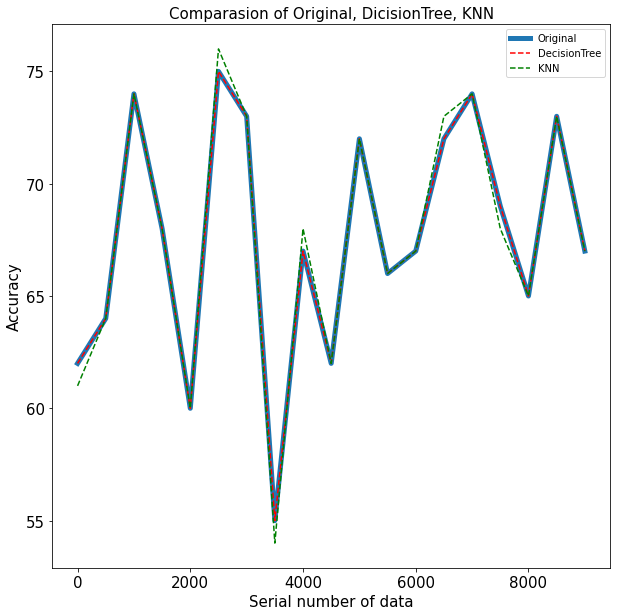

In [36]:
#comparasion between DecisionTree and KNN
x_axis = []
D_line = []
K_line = []
O_line = []
for i in range(0,len(test_data),500):
    x_axis.append(i)
    D_line.append(fifa_Dpredited[i])
    K_line.append(fifa_Kpredited[i])
    O_line.append(test_ovr['Overall'][i])
plt.figure(figsize=(10,10))
plt.title("Comparasion of Original, DicisionTree, KNN",fontsize=15) # title
plt.ylabel("Accuracy",fontsize=15) # y label
plt.xlabel("Serial number of data",fontsize=15) # x label
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(x_axis,O_line,linewidth = 5,label = 'Original')
plt.plot(x_axis,D_line,'--',color = 'red',label = 'DecisionTree')
plt.plot(x_axis,K_line,'--',color = 'green',label = 'KNN')
plt.legend()
plt.savefig("D:/FIFA19/Comparasion.png")
plt.show()